## Exploratory Data Analysis

In [1]:
#!pip install hvplot

In [41]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from dask import bag
from dask import diagnostics

import hvplot.pandas

import util

In [3]:
train_img_dir='../../data/train'
test_img_dir='../../data/test'
train_csv_path = '../../data/train.csv'
test_csv_path = '../../data/sample_submission.csv'

In [4]:
train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

In [6]:
train.head(10)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   25361 non-null  object
 1   Id      25361 non-null  object
dtypes: object(2)
memory usage: 396.4+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7960 entries, 0 to 7959
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   7960 non-null   object
 1   Id      7960 non-null   object
dtypes: object(2)
memory usage: 124.5+ KB


In [9]:
print('Check for number of unique values for each feature')
for col in train.columns:
    print(col+':'+str(len(train[col].unique())))

Check for number of unique values for each feature
Image:25361
Id:5005


In [10]:
label_count = train.Id.value_counts()

In [17]:
label_count[:20]

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
w_2b069ba      48
w_d405854      47
w_f0fe284      45
w_789c969      45
w_5e8e218      40
w_343f088      40
w_778e474      40
w_a9304b9      37
w_5a2634c      37
w_60ce6fc      37
Name: Id, dtype: int64

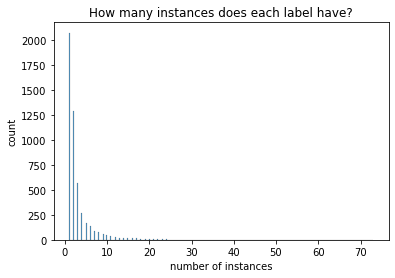

In [19]:
ax = sns.histplot(label_count[1:].tolist(),stat='count')
ax.set(title='How many images does each whale have?', xlabel='number of images', ylabel='count')
plt.show()

**General EDA summary**:
- No NA's
- Most images have 5 images or fewer. 2000+ images have only 1 image
- 5005 unique labels: 5004 individual whales and 'new_whale'

#### EDA: Images

In [43]:
train_img_path=util.get_all_img_path(train_img_dir)
test_img_path=util.get_all_img_path(test_img_dir)

In [46]:
sample_img = cv2.imread(train_img_path[0])

In [47]:
print(f'The shape of the image is: {sample_img.shape}')

The shape of the image is: (700, 1050, 3)


In [48]:
np.min(sample_img), np.max(sample_img)

(0, 255)

In [49]:
img_dim_bag = bag.from_sequence(train_img_path).map(lambda path: cv2.imread(path).shape)
with diagnostics.ProgressBar():
    dims = img_dim_bag.compute()

[########################################] | 100% Completed |  1min 36.4s


In [50]:
df_dims = pd.DataFrame(dims,columns=['height','width','color'])

In [51]:
df_dims.color.unique()

array([3], dtype=int64)

In [52]:
dim_count = df_dims.groupby(['height','width']).size().reset_index().rename(columns={0:'count'})

In [53]:
dim_count.sort_values('count',ascending=False)

,height,width,count
5254,700,1050,3330
4737,600,1050,2549
3226,450,1050,1556
4033,525,1050,1303
3755,500,700,667
...,...,...,...
2009,345,861,1
2008,345,816,1
2007,345,806,1
2006,345,805,1


In [54]:
dim_count.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1400), ylim=(0,1400), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0.3)

:Scatter   [height]   (width,count)

**Image EDA summary**:
- Images are of varying sizes, with widths mostly below 1050 and heights below 700.
- The images are usually wider.
- Every image is RGB, 0-255 colored.